<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import" data-toc-modified-id="Import-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import</a></span><ul class="toc-item"><li><span><a href="#Outils" data-toc-modified-id="Outils-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Outils</a></span></li><li><span><a href="#Lecture-du-dataframe" data-toc-modified-id="Lecture-du-dataframe-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Lecture du dataframe</a></span><ul class="toc-item"><li><span><a href="#Creation-d'un-dataframe-debug-equilibré" data-toc-modified-id="Creation-d'un-dataframe-debug-equilibré-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Creation d'un dataframe debug equilibré</a></span></li></ul></li></ul></li><li><span><a href="#Choix-d'un-modèle" data-toc-modified-id="Choix-d'un-modèle-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Choix d'un modèle</a></span><ul class="toc-item"><li><span><a href="#Roc-auc" data-toc-modified-id="Roc-auc-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Roc auc</a></span><ul class="toc-item"><li><span><a href="#split-des-données-en-Train-et-Test" data-toc-modified-id="split-des-données-en-Train-et-Test-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>split des données en Train et Test</a></span></li><li><span><a href="#Plot-de-la-courbe-ROC-pour-les-différents-modèles-testés" data-toc-modified-id="Plot-de-la-courbe-ROC-pour-les-différents-modèles-testés-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>Plot de la courbe ROC pour les différents modèles testés</a></span><ul class="toc-item"><li><span><a href="#Sur-les-données-telles-quelles" data-toc-modified-id="Sur-les-données-telles-quelles-2.1.2.1"><span class="toc-item-num">2.1.2.1&nbsp;&nbsp;</span>Sur les données telles quelles</a></span></li><li><span><a href="#Sur-les-données-debug-equilibrés" data-toc-modified-id="Sur-les-données-debug-equilibrés-2.1.2.2"><span class="toc-item-num">2.1.2.2&nbsp;&nbsp;</span>Sur les données debug equilibrés</a></span></li></ul></li></ul></li></ul></li><li><span><a href="#Bibliography" data-toc-modified-id="Bibliography-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Bibliography</a></span></li></ul></div>

# Import


In [ ]:
import numpy as np
import pandas as pd
import gc
import time
import re
from contextlib import contextmanager
from lightgbm import LGBMClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier

from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)




## Outils

J'aurais pu les mettre dans un fichier py, mais je préfère les voir

In [2]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))


In [3]:
def readdf(debug=True):
    savedataframe = "debugdataframe.csv" if debug else "apidataframe.csv"
    df = pd.read_csv(savedataframe)
    print("Reading",savedataframe)
    print("Shape",df.shape)
    return df

In [4]:
def prepare_train_df(df):
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    del df
    gc.collect()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    train_x, train_y, apptest = train_df[feats], train_df['TARGET'], test_df[feats]
    return train_x, train_y, apptest


In [5]:
def infinity(df):
    # checking for infinity pour le ValueError: Input X contains infinity or a value too large for dtype('float64').
    print()
    print("checking for infinity")
  
    ds = df.isin([np.inf, -np.inf])
  
    # printing the count of infinity values
    print()
    print("printing the count of infinity values")
  
    count = np.isinf(df).values.sum()
    print("It contains " + str(count) + " infinite values")
    
    # printing column name where infinity is present
    print()
    print("printing column name where infinity is present")
    col_name = df.columns.to_series()[np.isinf(df).any()]
    print(col_name)
  
    # printing row index with infinity
    print()
    print("printing row index with infinity ")
  
    r = df.index[np.isinf(df).any(1)]
    print(r)

## Lecture du dataframe

In [9]:
# default mode debug=True pour tester avec un petit echantillon

df=readdf(False) #False=lire tout le fichier mergé

Reading apidataframe.csv
Shape (356251, 527)


### Creation d'un dataframe debug equilibré

In [7]:
dfall=readdf(False)

Reading apidataframe.csv
Shape (356251, 527)


In [10]:
df_0 = dfall[dfall['TARGET']==0].sample(5000)
df_1 = dfall[dfall['TARGET']==1].sample(5000)
df_test=dfall[dfall['TARGET'].isnull()].sample(10000)
df50=df_0.append(df_1, ignore_index=True).append(df_test, ignore_index=True)
display(df50.shape)
display(df50['TARGET'].value_counts())
df50.head()

(20000, 527)

0.0    5000
1.0    5000
Name: TARGET, dtype: int64

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,CC_NAME_CONTRACT_STATUS_Refused_SUM,CC_NAME_CONTRACT_STATUS_Sentproposal_MIN,CC_NAME_CONTRACT_STATUS_Sentproposal_MAX,CC_NAME_CONTRACT_STATUS_Sentproposal_MEAN,CC_NAME_CONTRACT_STATUS_Sentproposal_SUM,CC_NAME_CONTRACT_STATUS_Signed_MIN,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_COUNT
0,112927,230984,0.0,1,0,135000.0,288873.0,19435.5,238500.0,0.002042,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10369,112073,0.0,0,0,225000.0,871029.0,42034.5,765000.0,0.003818,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0
2,113906,232105,0.0,1,0,103500.0,463284.0,17595.0,382500.0,0.019689,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,118080,236925,0.0,0,1,292500.0,1732500.0,45832.5,1732500.0,0.018634,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,103208,219794,0.0,0,0,166500.0,266832.0,24601.5,238500.0,0.030755,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Choix d'un modèle

LGBMClassifier semble etre gagnant dans le concours Kaggle. 
Je le compare avec quelques autres classifiers de differents types.


In [11]:
classifiers = { 'Dummy Classifier': DummyClassifier(),
                'Logistic Regression': LogisticRegression(),
                'K Neighbors': KNeighborsClassifier(),
                'Random Forest': RandomForestClassifier(),
                'LGBM': LGBMClassifier()
              }

Pour les autres classifiers if faut imputer et scaler les données

In [12]:
preprocess  = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler()),
])

## Roc auc

The Receiver Operating Characteristic (ROC) curve graphs the true positive rate versus the false positive rate:

A single line on the graph indicates the curve for a single model, and movement along a line indicates changing the threshold used for classifying a positive instance. The threshold starts at 0 in the upper right to and goes to 1 in the lower left. A curve that is to the left and above another curve indicates a better model. For example, the blue model is better than the red model, which is better than the black diagonal line which indicates a naive random guessing model.

The Area Under the Curve (AUC) explains itself by its name! It is simply the area under the ROC curve. (This is the integral of the curve.) This metric is between 0 and 1 with a better model scoring higher. A model that simply guesses at random will have an ROC AUC of 0.5.

When we measure a classifier according to the ROC AUC, we do not generation 0 or 1 predictions, but rather a probability between 0 and 1.

https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html

### split des données en Train et Test


In [13]:
def prepare_train_df(df):
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    del df
    gc.collect()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    train_x, train_y = train_df[feats], train_df['TARGET']
    display(train_x.shape)
    #train_x=train_x.astype(np.float64)
    display(train_y.value_counts())
    return train_x, train_y


In [14]:
X,y = prepare_train_df(df)
X50,y50 = prepare_train_df(df50)
infinity(dfall)


(307507, 524)

0.0    282682
1.0     24825
Name: TARGET, dtype: int64

(10000, 524)

0.0    5000
1.0    5000
Name: TARGET, dtype: int64


checking for infinity

printing the count of infinity values
It contains 0 infinite values

printing column name where infinity is present
Series([], dtype: object)

printing row index with infinity 
Int64Index([], dtype='int64')


### Plot de la courbe ROC pour les différents modèles testés

#### Sur les données telles quelles

In [15]:
def plot_roc_curve(classifiers, preprocessor, X, y, n_splits=6, fit=True):

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=1)    
    for clf_name, classifier in classifiers.items():
      with timer(clf_name):  
        print('Testing',clf_name)
        tprs = []
        aucs = []
        mean_fpr = np.linspace(0, 1, 100)
        for n_fold, (train, test) in enumerate(kf.split(X, y)):

            pipeline = Pipeline(
                    [
                     ('preprocessing', preprocessor),
                     ('clf', classifier)
                    ]
            )
            
            if fit :
                pipeline.fit(X.iloc[train, :], y.iloc[train])

            y_pred_grd = pipeline.predict_proba(X.iloc[test, :])[:, 1]
            fpr, tpr, _ = roc_curve(y.iloc[test], y_pred_grd)

            interp_tpr = np.interp(mean_fpr, fpr, tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            auc_ = auc(fpr, tpr)
            print(' Auc fold',n_fold,":",auc_)
            aucs.append(auc_)

        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)
        plt.plot(mean_fpr, mean_tpr,
            label=clf_name + r' (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2,
            alpha=.8)

    plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()


Testing Dummy Classifier
 Auc fold 0 : 0.5
 Auc fold 1 : 0.5
 Auc fold 2 : 0.5
 Auc fold 3 : 0.5
 Auc fold 4 : 0.5
 Auc fold 5 : 0.5
Dummy Classifier - done in 243s
Testing Logistic Regression


/Users/mcBedini/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


 Auc fold 0 : 0.4981488732330853


/Users/mcBedini/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


 Auc fold 1 : 0.5008865571484407


/Users/mcBedini/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


 Auc fold 2 : 0.49954464822232736


/Users/mcBedini/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


 Auc fold 3 : 0.4927347831887243


/Users/mcBedini/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


 Auc fold 4 : 0.48941381873324363


/Users/mcBedini/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


 Auc fold 5 : 0.4957140184815832
Logistic Regression - done in 379s
Testing K Neighbors
 Auc fold 0 : 0.5563901830234231
 Auc fold 1 : 0.5554592033487992
 Auc fold 2 : 0.545284226702029
 Auc fold 3 : 0.5500776438103478
 Auc fold 4 : 0.5448875669457618
 Auc fold 5 : 0.550883563444976
K Neighbors - done in 3264s
Testing Random Forest
 Auc fold 0 : 0.7242717727059023
 Auc fold 1 : 0.727361640340947
 Auc fold 2 : 0.7261080124583575
 Auc fold 3 : 0.7213680683703865
 Auc fold 4 : 0.7184311179292844
 Auc fold 5 : 0.7247568619758439
Random Forest - done in 2952s
Testing LGBM
 Auc fold 0 : 0.7791894207250624
 Auc fold 1 : 0.790226615996781
 Auc fold 2 : 0.7796056424874837
 Auc fold 3 : 0.7793201845599648
 Auc fold 4 : 0.7773762927831896
 Auc fold 5 : 0.780102332807421
LGBM - done in 373s


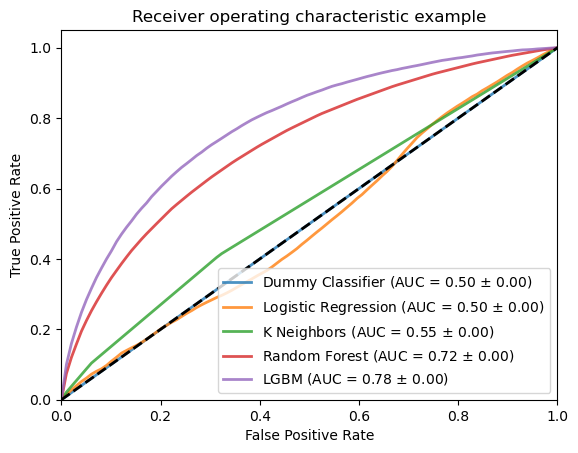

In [16]:
plot_roc_curve(classifiers, preprocess, X,y)

Le classifier LGBM du kernel choisi se confirme le meilleur. 

#### Sur les données debug equilibrés

Testing Dummy Classifier
 Auc fold 0 : 0.5
 Auc fold 1 : 0.5
 Auc fold 2 : 0.5
 Auc fold 3 : 0.5
 Auc fold 4 : 0.5
 Auc fold 5 : 0.5
Dummy Classifier - done in 6s
Testing Logistic Regression


/Users/mcBedini/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


 Auc fold 0 : 0.6026392074597448


/Users/mcBedini/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


 Auc fold 1 : 0.5828151774785801


/Users/mcBedini/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


 Auc fold 2 : 0.5774553410775719


/Users/mcBedini/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


 Auc fold 3 : 0.5985565359166471


/Users/mcBedini/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


 Auc fold 4 : 0.5828816256862113


/Users/mcBedini/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


 Auc fold 5 : 0.5873061645267568
Logistic Regression - done in 10s
Testing K Neighbors
 Auc fold 0 : 0.5896088590232713
 Auc fold 1 : 0.5674778601771187
 Auc fold 2 : 0.5596594262354077
 Auc fold 3 : 0.5594337910592221
 Auc fold 4 : 0.5789315864741431
 Auc fold 5 : 0.602849768947395
K Neighbors - done in 10s
Testing Random Forest
 Auc fold 0 : 0.7371202123122673
 Auc fold 1 : 0.7238757289941681
 Auc fold 2 : 0.7304637906464567
 Auc fold 3 : 0.7360917871473797
 Auc fold 4 : 0.7100245940397657
 Auc fold 5 : 0.7418785550020546
Random Forest - done in 39s
Testing LGBM
 Auc fold 0 : 0.7476789151557763
 Auc fold 1 : 0.7508387932896536
 Auc fold 2 : 0.7545148335276591
 Auc fold 3 : 0.7638808472393857
 Auc fold 4 : 0.7337875397887162
 Auc fold 5 : 0.764975164548384
LGBM - done in 21s


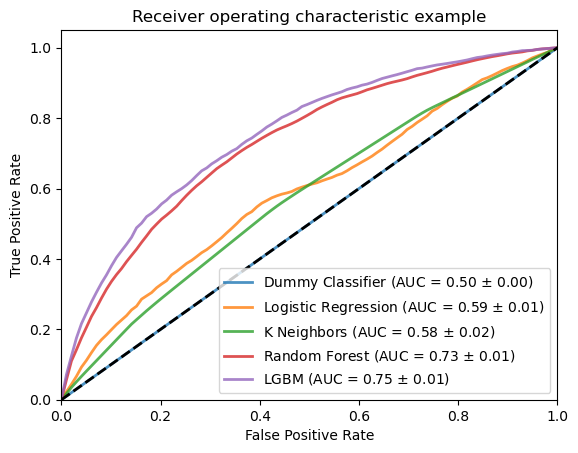

In [17]:
plot_roc_curve(classifiers, preprocess, X50,y50)

In [18]:
#sauvegarde du fichier debug équilibré, pour des tests
df50.to_csv('df50.csv', index= False)


# Bibliography

Light gbm

https://towardsdatascience.com/how-to-beat-the-heck-out-of-xgboost-with-lightgbm-comprehensive-tutorial-5eba52195997

https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html


Auc Roc

https://www.analyticsvidhya.com/blog/2020/06/auc-roc-curve-machine-learning/

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html

https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5

